# Data Modeling

[QuickDBD](https://app.quickdatabasediagrams.com/#/)
```
# Physical

departments
-
dept_no varchar(10) PK
dept_name varchar(30)

titles
-
title_id varchar(10) PK
title varchar(30)

employees
-
emp_no int PK
emp_title_id varchar(10) FK >- titles.title_id
birth_date date
first_name varchar(30)
last_name varchar(30)
sex varchar(1)
hire_date date

salaries
-
emp_no int PK FK - employees.emp_no
salary int

dept_emp
-
emp_no int PK FK >- employees.emp_no
dept_no varchar(10) PK FK >- departments.dept_no

dept_manager
-
dept_no varchar(10) FK >- departments.dept_no
emp_no int PK FK - employees.emp_no
```

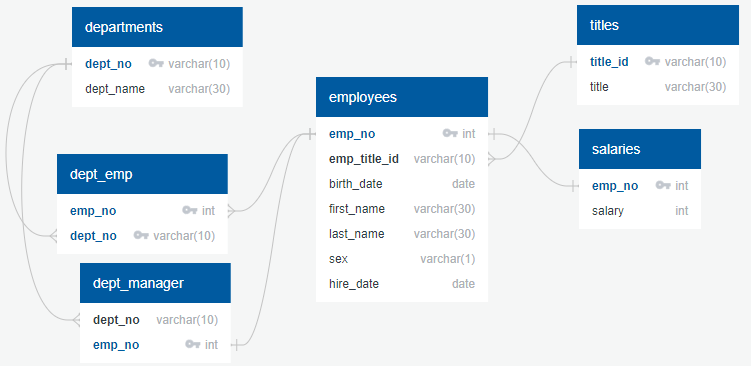

In [1]:
from IPython.display import Image
Image(filename='./EmployeeSQL/quickdbd_erd.png') 

# Data Engineering

Use the provided information to create a table schema for each of the six CSV files. Be sure to do the following:
- Remember to specify the data types, primary keys, foreign keys, and other constraints.
- For the primary keys, verify that the column is unique. Otherwise, create a composite key, which takes two primary keys to uniquely identify a row.
- Be sure to create the tables in the correct order to handle the foreign keys.

Import each CSV file into its corresponding SQL table

In [1]:
# create table and read in each csv to confirm PKs are unique (should get error for PKs)

# titles Unique
# salaries 300024 rows, emp_no
# employees 300024 rows, emp_no
# dept_manager 24 rows, emp_no
# departments Unique
# dept_emp 331603 rows, emp_no has duplicates; make composite key

### Schema

```sql
drop table if exists departments;
drop table if exists titles;
drop table if exists employees;
drop table if exists salaries;
drop table if exists dept_emp;
drop table if exists dept_manager;

create table departments (
	dept_no varchar(10) primary key not null,
	dept_name varchar(30) not null
);

create table titles (
	title_id varchar(10) primary key not null,
	title varchar(30) not null
);

create table employees (
	emp_no int primary key not null,
	emp_title_id varchar(10) not null,
	foreign key (emp_title_id) references titles(title_id),
	birth_date date not null,
	first_name varchar(30) not null,
	last_name varchar(30) not null,
	sex varchar(1) not null,
	hire_date date
);

create table salaries (
	emp_no int primary key not null,
	foreign key (emp_no) references employees(emp_no),
	salary int not null
);

create table dept_emp (
	emp_no int not null,
	foreign key (emp_no) references employees(emp_no),
	dept_no varchar(10) not null,
	foreign key (dept_no) references departments(dept_no),
	primary key (emp_no, dept_no)
);

create table dept_manager (
	dept_no varchar(10) not null,
	foreign key (dept_no) references departments(dept_no),
	emp_no int primary key not null,
	foreign key (emp_no) references employees(emp_no)
);
```

```sql
select * from departments;
select * from titles;
select * from employees;
select * from salaries;
select * from dept_emp;
select * from dept_manager;

copy departments from 'departments.csv' delimiter ',' csv header;
copy titles from 'titles.csv' delimiter ',' csv header;
copy employees from 'employees.csv' delimiter ',' csv header;
copy salaries from 'salaries.csv' delimiter ',' csv header;
copy dept_emp from 'dept_emp.csv' delimiter ',' csv header;
copy dept_manager from 'dept_manager.csv' delimiter ',' csv header;
```

# Data Analysis

```sql
-- List employee number, last name, first name, sex, and salary of each employee.
select e.emp_no, e.last_name, e.first_name, e.sex, s.salary
from employees as e
inner join salaries as s on e.emp_no = s.emp_no
order by e.emp_no asc;

-- List the first name, last name, and hire date for the employees who were hired in 1986.
select first_name, last_name, hire_date
from employees
where date_part('Year', hire_date) = 1986
order by hire_date asc;

--List the manager of each department along with their department number, department name,
--employee number, last name, and first name.
select d.dept_no, d.dept_name, e.emp_no, e.last_name, e.first_name
from employees as e
inner join dept_manager as m on m.emp_no = e.emp_no
inner join departments as d on d.dept_no = m.dept_no
order by d.dept_no asc, e.last_name asc;

--List the department number for each employee along with that employee’s employee number, last name,
--first name, and department name.
select de.dept_no, de.emp_no, e.last_name, e.first_name, d.dept_name
from dept_emp as de
inner join departments as d on d.dept_no = de.dept_no
inner join employees as e on e.emp_no = de.emp_no
order by emp_no asc, dept_no asc;

--List first name, last name, and sex of each employee whose first name is Hercules
--and whose last name begins with the letter B.
select first_name, last_name, sex
from employees
where first_name = 'Hercules'
and last_name like 'B%'
order by last_name asc;

--List each employee in the Sales department, including their employee number, last name, and first name.
select de.emp_no, e.last_name, e.first_name
from dept_emp as de
inner join employees as e on e.emp_no = de.emp_no
where de.dept_no in
(
	select dept_no from departments
	where dept_name = 'Sales'
);

--List each employee in the Sales and Development departments, including their employee number, last name,
--first name, and department name.
select de.emp_no, e.last_name, e.first_name, d.dept_name
from dept_emp as de
inner join employees as e on e.emp_no = de.emp_no
inner join departments as d on d.dept_no = de.dept_no
where de.dept_no in
(
	select dept_no from departments
	where dept_name = 'Sales'
	or dept_name = 'Development'
);

--List the frequency counts, in descending order, of all the employee last names
--(that is, how many employees share each last name).
select last_name, count(last_name)
from employees
group by last_name
order by count(last_name) desc;
```

### Additional intermediate queries

```sql
-- table dept_emp; employees in two departments; 31579 results
select emp_no, count(emp_no)
from dept_emp
group by emp_no
having count(emp_no) > 1
order by count(emp_no) desc;

-- subquery two-step (sales question)
select dept_no from departments
where dept_name = 'Sales';

select * from dept_emp
where dept_no in
(
	select dept_no from departments
	where dept_name = 'Sales'
);

-- subquery two-step (sales and development question)
select dept_no from departments
where dept_name = 'Sales'
or dept_name = 'Development';

select * from dept_emp
where dept_no in
(
	select dept_no from departments
	where dept_name = 'Sales'
	or dept_name = 'Development'
);
```